# Setup

In [ ]:
import torch
import requests
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models
from torch import nn, tensor
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from fastcore.all import *
from miniai.learner import *
from miniai.datasets import show_image, show_images

In [ ]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?auto=compress&cs=tinysrgb&w=512"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?auto=compress&cs=tinysrgb&w=512"

In [ ]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading Images

In [ ]:
def download_image(url, size=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    if size != None: image = image.resize(size)
    return transforms.ToTensor()(image)

content_im.shape: torch.Size([3, 256, 256])


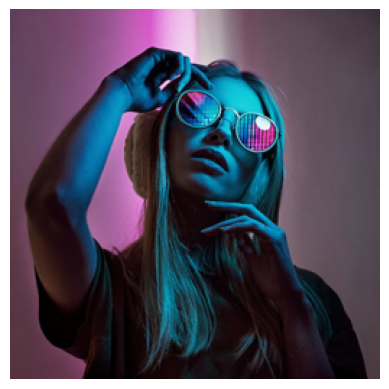

In [ ]:
content_im = download_image(face_url, size=(256, 256)).to(device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [ ]:
content_im.min(),content_im.max() # Check bounds

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

# Optimizing Images

In [ ]:
class PixelGenerator(nn.Module):
    def __init__(self, size=256, init_image_tensor=None):
        super().__init__()
        self.im_array = nn.Parameter(torch.rand(3, size, size))
        if init_image_tensor != None: self.im_array = nn.Parameter(init_image_tensor.clone())
    def forward(self): return self.im_array

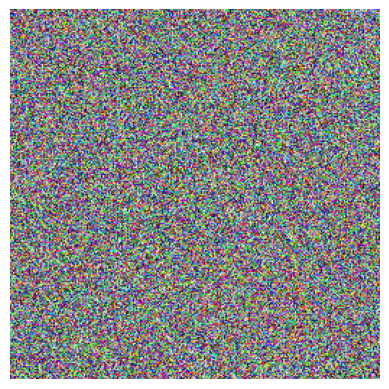

In [ ]:
model = PixelGenerator()
show_image(model());

In [ ]:
class DummyDataset():
    def __init__(self, length=1, x=0, y=0): store_attr()
    def __len__(self): return self.length
    def __getitem__(self, idx): return self.x, self.y

def get_dummy_dls(length=100):
    dl = DataLoader(DummyDataset(length=length), batch_size=1)
    valid_dl = DataLoader(DummyDataset(length=1), batch_size=1)
    return DataLoaders(dl, valid_dl)

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im.to(device))

model = PixelGenerator()
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

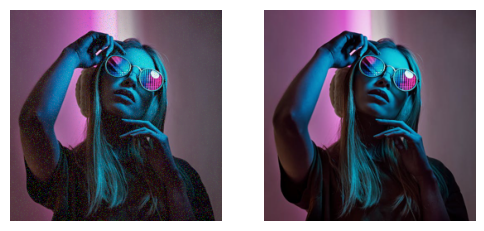

In [ ]:
show_images([learn.model().clip(0, 1), content_im]);

## Viewing progress

In [ ]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(learn.preds.clip(0, 1))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

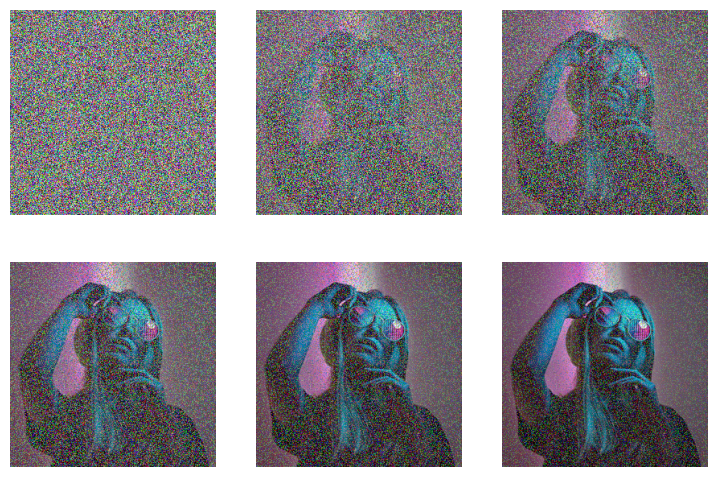

In [ ]:
model = PixelGenerator()
learn = Learner(model, get_dummy_dls(50), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB()])

## Getting Features from VGG16

### Load VGG network

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)
# vgg16 # Uncomment to see network arch

### Normalize Images

In [ ]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [ ]:
# Try 1 (won't work):
# (content_im - imagenet_mean) / imagenet_std

In [ ]:
imagenet_mean.shape

torch.Size([3])

In [ ]:
content_im.shape

torch.Size([3, 256, 256])

In [ ]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
# Try 2:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [ ]:
# And with torchvision transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

### Get intermediate representations, take 1:

In [ ]:
def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16.features[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [ ]:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

In [ ]:
# Exercise: Can you do this using hooks?

### What's the point?

In [ ]:
# Show perceptual loss (maybe show some pics from distil.pub or something?)
# https://distill.pub/2017/feature-visualization/

# Optimizing an Image with Content Loss

In [ ]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=[18, 25]):
        store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))

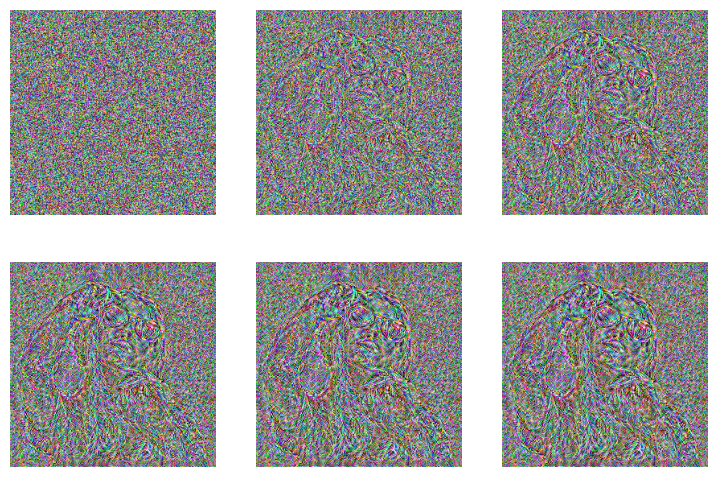

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = PixelGenerator()
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

**Choosing the layers determines the kind of features that are important:**

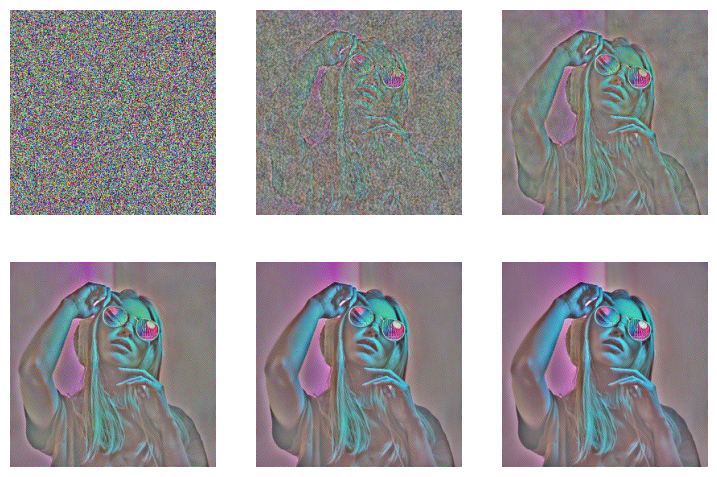

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=[1, 6])
model = PixelGenerator()
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

# Style Loss with Gram Matrix

So, we know how to extract feature maps... they still encode spatial info.

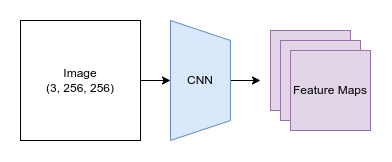

Gram matrix... 

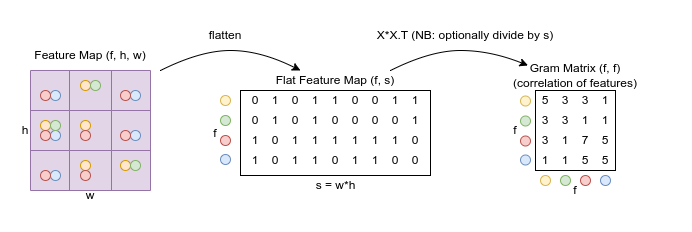

In [ ]:
# TODO try to explain gram matrices :)

In [ ]:
t = torch.tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 0]])
t

tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 0]])

In [ ]:
torch.einsum('fs, gs -> fg', t, t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [ ]:
t.matmul(t.T)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

### Trying it out

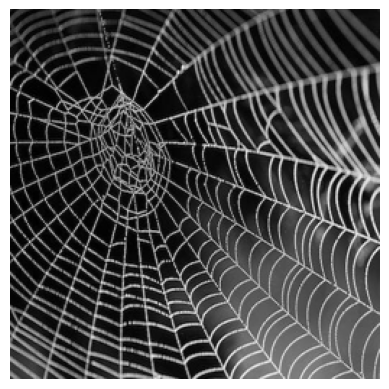

In [ ]:
style_im = download_image(spiderweb_url, size=(256, 256)).to(device)
show_image(style_im);

In [ ]:
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return [torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers)]

In [ ]:
style_grams = calc_grams(style_im)
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [ ]:
def calc_style_loss(grams_x, grams_y):
    return sum((x-y).square().mean() for x, y in zip(grams_x, grams_y))

In [ ]:
with torch.no_grad():
    print(calc_style_loss(calc_grams(content_im), calc_grams(style_im)))

tensor(356.1602, device='cuda:0')


In [ ]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): return calc_style_loss(calc_grams(input_im), self.target_grams)

In [ ]:
style_loss = StyleLossToTarget(style_im)

In [ ]:
style_loss(content_im)

tensor(356.1602, device='cuda:0', grad_fn=<AddBackward0>)

## Style Transfer

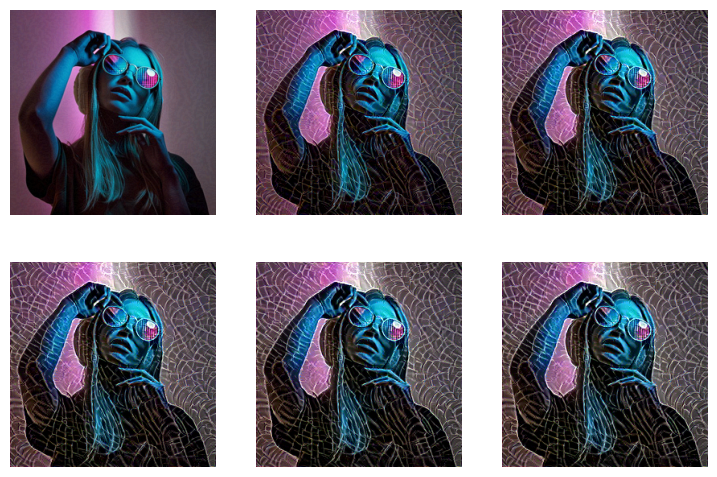

In [ ]:
model = PixelGenerator(init_image_tensor = content_im)
style_loss = StyleLossToTarget(style_im.to(device))
content_loss = ContentLossToTarget(content_im.to(device))
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

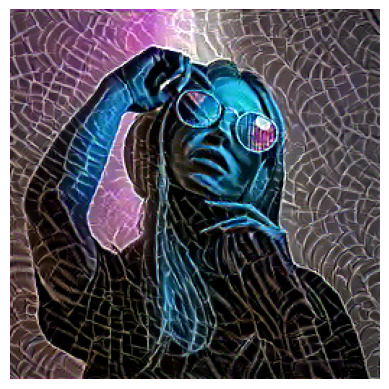

In [ ]:
show_image(learn.model().clip(0, 1));

In [ ]:
# Talk about when you move from this to Learner, and HW is add cool progress bar things etc